In [1]:
# imports
import regex
import sys
sys.path.append( '..' )

from FIA.FIA import *
from ML.ML4com import *
from plot import *

In [2]:
c = 0
with open("../../runs/FIA/all_x_com8/merged/data_matrix.tsv", "r") as file:
    for i, line in tqdm(enumerate(file)):
        if i > 0:
            break
        print(line.count("\t"))

1it [00:00, 263.74it/s]

2186


In [3]:
report_dir = f"../../reports/ML"

source = "Com8_equal_conc_comb"

algorithms = ["Decision tree", "Extreme gradient boosting RF", "Gaussian Naive-Bayes", "K-neighbours classifier", "Linear Discriminant Analysis",
              "Logistic Regression", "Neural Network (MLP) SK-learn", "Random forest", "Support-vector classifier"]
metrics = ["metrics", "organism_metrics", "overall_metrics"]

vae_red_methods = {"Cosine": "cosine_2", "MAE": "mae_2", "MAE+Cosine": "mae_cosine_2", "Spectral Entropy": "se_2",
                   "MSE": "mse_2", "AE+Cosine": "ae+cosine_2"}
dim_red_methods = {"VAE-Cosine": "cosine_2", "VAE-MAE": "mae_2", "VAE-MAE+Cosine": "mae_cosine_2", "VAE-Spectral Entropy": "se_2",
                   "VAE-MSE": "mse_2", "VAE-AE+Cosine": "ae+cosine_2", "Annotation": ""}

In [4]:
def add_methodology(df, dim_red_method:str, classification_algorithm:str):
    df["Dimensionality reduction method"] = pd.Series([dim_red_method]*len(df))
    df["Classification algorithm"] = pd.Series([classification_algorithm]*len(df))
    return df

def str_to_np_ndarray(bracketed_string:str, sep:str) -> np.ndarray:
    bracketed_string = bracketed_string[1:-1]
    if "[" in bracketed_string:
        split = regex.findall(r'\[(?:[^][]|(?R))*\]', bracketed_string)
        return np.array([str_to_np_ndarray(bracketed_string, sep) for bracketed_string in split])
    else:
        return np.fromstring(bracketed_string, sep=sep)

In [5]:
def collect_all_dr_methods(dim_red_methods, metrics_level):
    dr_dfs = []
    for dim_red_method, recon_loss in dim_red_methods.items():
        project = source if "nnot" in dim_red_method else f"{source}_{recon_loss}"
        dr_category = "annot" if "nnot" in dim_red_method else "latent"
        for algorithm in algorithms:
            path = os.path.join("../../runs/ML/", dr_category, project, f"{algorithm}_{metrics_level}.tsv")
            algorithm = algorithm.replace("SK-learn", "")
            algorithm = algorithm.replace(" RF", "")
            df = add_methodology( pd.read_csv( path, sep="\t", index_col=0),
                                        dim_red_method=dim_red_method, classification_algorithm=algorithm)
            df["TPR"] = df["TPR"].apply(lambda x: str_to_np_ndarray(x, " "))
            df["FPR"] = df["FPR"].apply(lambda x: str_to_np_ndarray(x, " "))
            df["Threshold"] = df["Threshold"].apply(lambda s: s.replace("inf", "1."))
            df["Threshold"] = df["Threshold"].apply(lambda x: str_to_np_ndarray(x, " "))
            df["Conf_Mat"] = df["Conf_Mat"].apply(lambda x: str_to_np_ndarray(x, " "))
            dr_dfs.append(df)
    return dr_dfs

dr_dfs = collect_all_dr_methods(dim_red_methods, metrics[0])
vr_dfs = collect_all_dr_methods(vae_red_methods, metrics[0])

FileNotFoundError: [Errno 2] No such file or directory: '../../runs/ML/annot/Com8_equal_conc_comb/Linear Discriminant Analysis_metrics.tsv'

In [ ]:
dr_dfs = pd.concat( dr_dfs )
vr_dfs = pd.concat( vr_dfs )
cfa = "Classification algorithm"
acc = "Accuracy"
drm = "Dimensionality reduction method"
org = "Organism"

## DimRed results

In [ ]:
def plot_dimred_results(df, x, y, hue, plottype, outpath, suffix=""):
    hue_order = list(df.groupby(hue)[y].mean().sort_values(ascending=False).index)
    sns.reset_defaults()
    if plottype=="cat":
        sns.set_style("darkgrid")
        ax = sns.catplot(
            data=df, x=x, y=y, hue=hue, hue_order=hue_order,
            kind="point", alpha=0.85, errorbar="se", aspect=1.7,
            palette=sns.blend_palette(["crimson", "gold", "violet", "turquoise", "mediumblue"], n_colors=len(hue_order), as_cmap=False),
            err_kws={"linewidth": 2.0, "alpha": 0.5},
            markersize=5
            #palette=sns.diverging_palette(30, 240, l=65, sep=1, center="dark", as_cmap=False, n=9)
        )
        ax.tick_params(axis='x', labelrotation=0, labelsize=9)
        plt.xlabel("VAE loss function")
        plt.title(f"{y} of classifiers vs. VAE loss function", fontdict= { 'fontsize': 11, 'fontweight':'bold'})
    if plottype=="box":
        sns.set_style("darkgrid")
        sns.set(rc={"figure.figsize":(10, 6)})
        hue = x
        ax = sns.boxplot(
            data=df, x=x, y=y, hue=hue,
            palette="vlag"
        )
        ax.tick_params(axis='x', labelrotation=0, labelsize=10)
    if plottype=="violin":
        sns.set_style("darkgrid")
        sns.set(rc={"figure.figsize":(10, 6)})
        hue = x
        ax = sns.violinplot(
            data=df, x=x, y=y, hue=hue,
            palette="vlag", cut=0, inner="box"
        )
        ax.tick_params(axis='x', labelrotation=0, labelsize=10)
        plt.title(f"{y} of classifiers vs. {x}", fontdict= { 'fontsize': 11, 'fontweight':'bold'})
    plt.savefig(os.path.join(outpath, f"{plottype}_{x}_{y}_{hue}{suffix}.png"), bbox_inches="tight", dpi=600)
    plt.show()

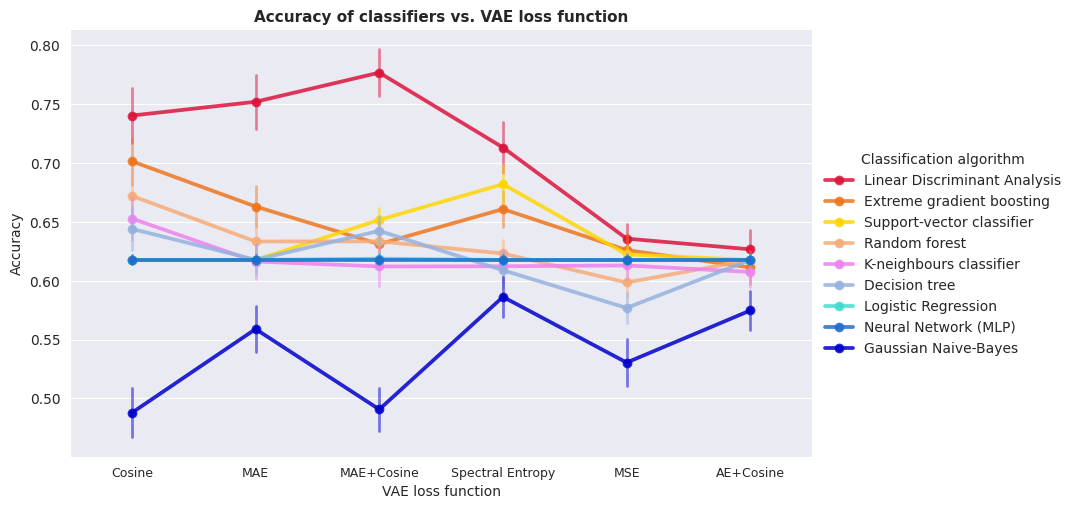

In [ ]:
plot_dimred_results(df=vr_dfs, x=drm, y=acc, hue=cfa, plottype="cat", outpath=report_dir, suffix="latent")

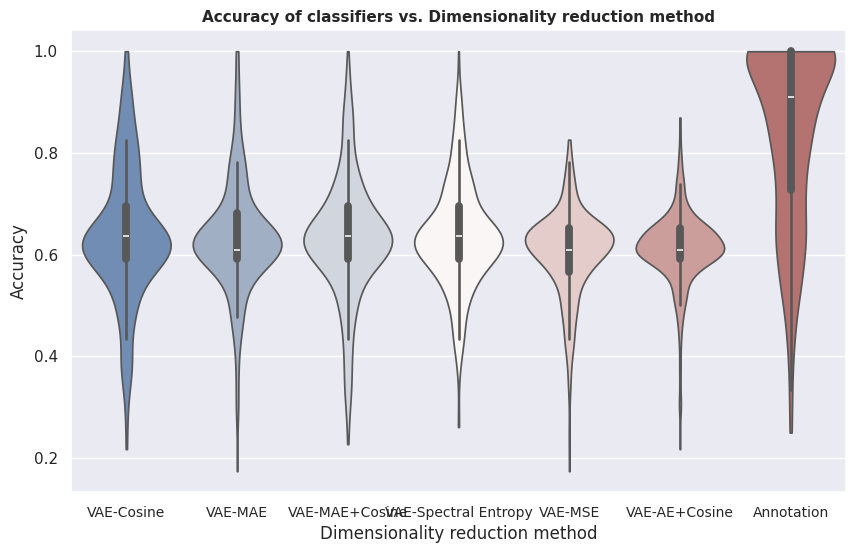

In [ ]:
plot_dimred_results(df=dr_dfs, x=drm, y=acc, hue=cfa, plottype="violin", outpath=report_dir, suffix="latent")

## Single AUC

In [ ]:
import matplotlib.text as txt

In [ ]:
ax = sns.lineplot( pd.DataFrame({"TPR": [0., 1.], "FPR": [0., 1.], "1": [" ", " "]}), x="FPR", y="TPR", hue="1")
legend = ax.axes.get_legend()
max_label_width = np.max([t.get_window_extent().x1 for t in legend.texts])
print(max_label_width)
plt.close()

4.875


In [ ]:
def plot_auc(dim_red_methods, metrics_level, group, group_ids, hue, outpath, suffix=""):
    plt.close()
    df = pd.concat( collect_all_dr_methods(dim_red_methods, metrics_level) )
    plt_df = pd.concat( [df[df[group] == group_id] for group_id in group_ids] ).reset_index(drop=True)

    if len(group_ids) > 1:
        for i, row in plt_df.iterrows():
            plt_df.loc[i, hue] = f"{row[group]} - {row[hue]}"


    ax = sns.lineplot( plt_df.explode(["TPR", "FPR"]), x="FPR", y="TPR", hue=hue, alpha=0.5)
    ax = sns.lineplot( pd.DataFrame({"TPR": [0., 1.], "FPR": [0., 1.], hue: ["Reference", "Reference"]}), x="FPR", y="TPR", hue=hue,
                    alpha=0.5, ax=ax, palette='Greys', linestyle='--')
    fig = ax.get_figure()

    legend = ax.axes.get_legend()
    legend.set_title(f"{hue} (AUC)")
    whitespace_width = 4.875
    max_label_width = np.max([t.get_window_extent().x1 for t in legend.texts])
    for i, t in enumerate(legend.texts):
        text = t.get_text()
        diff_extend = max_label_width - t.get_window_extent().x1
        whitspace_fill_count = int(np.round(diff_extend / whitespace_width)) + 2
        row = plt_df[plt_df[hue] == text]
        auc = 0.5 if row.empty else np.round(np.mean(row["AUC"]), 3)
        text = f'{text}{" "*whitspace_fill_count}({auc})'
        t.set_text(text)

    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    if len(group_ids) > 1 else group_ids[0]:
        title_text = " + ".join(group_ids)
    if len(dim_red_methods) == 1:
        title_text += f" - {list(dim_red_methods.keys())[0]}"

         
    plt.title(f"ROC curve - {title_text}")
    plt.savefig(os.path.join(outpath, f"AUC_{hue}_{group}_{title_text}{suffix}.png"), bbox_inches="tight", dpi=600)
    plt.show()

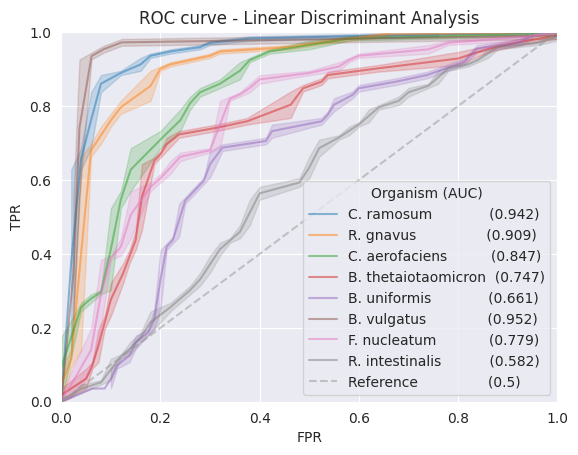

In [ ]:
plot_auc(dim_red_methods={'VAE-MAE+Cosine': 'mae_cosine_2'}, metrics_level=metrics[1],
         group=cfa, group_ids=["Linear Discriminant Analysis"],
         hue=org, outpath=report_dir, suffix="")

In [ ]:
algorithms

['Decision tree',
 'Extreme gradient boosting RF',
 'Gaussian Naive-Bayes',
 'K-neighbours classifier',
 'Linear Discriminant Analysis',
 'Logistic Regression',
 'Neural Network (MLP) SK-learn',
 'Random forest',
 'Support-vector classifier']

In [ ]:
dim_red_methods

{'VAE-Cosine': 'cosine_2',
 'VAE-MAE': 'mae_2',
 'VAE-MAE+Cosine': 'mae_cosine_2',
 'VAE-Spectral Entropy': 'se_2',
 'VAE-MSE': 'mse_2',
 'VAE-AE+Cosine': 'ae+cosine_2',
 'Annotation': ''}

## Classifiers

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

NameError: name 'os' is not defined

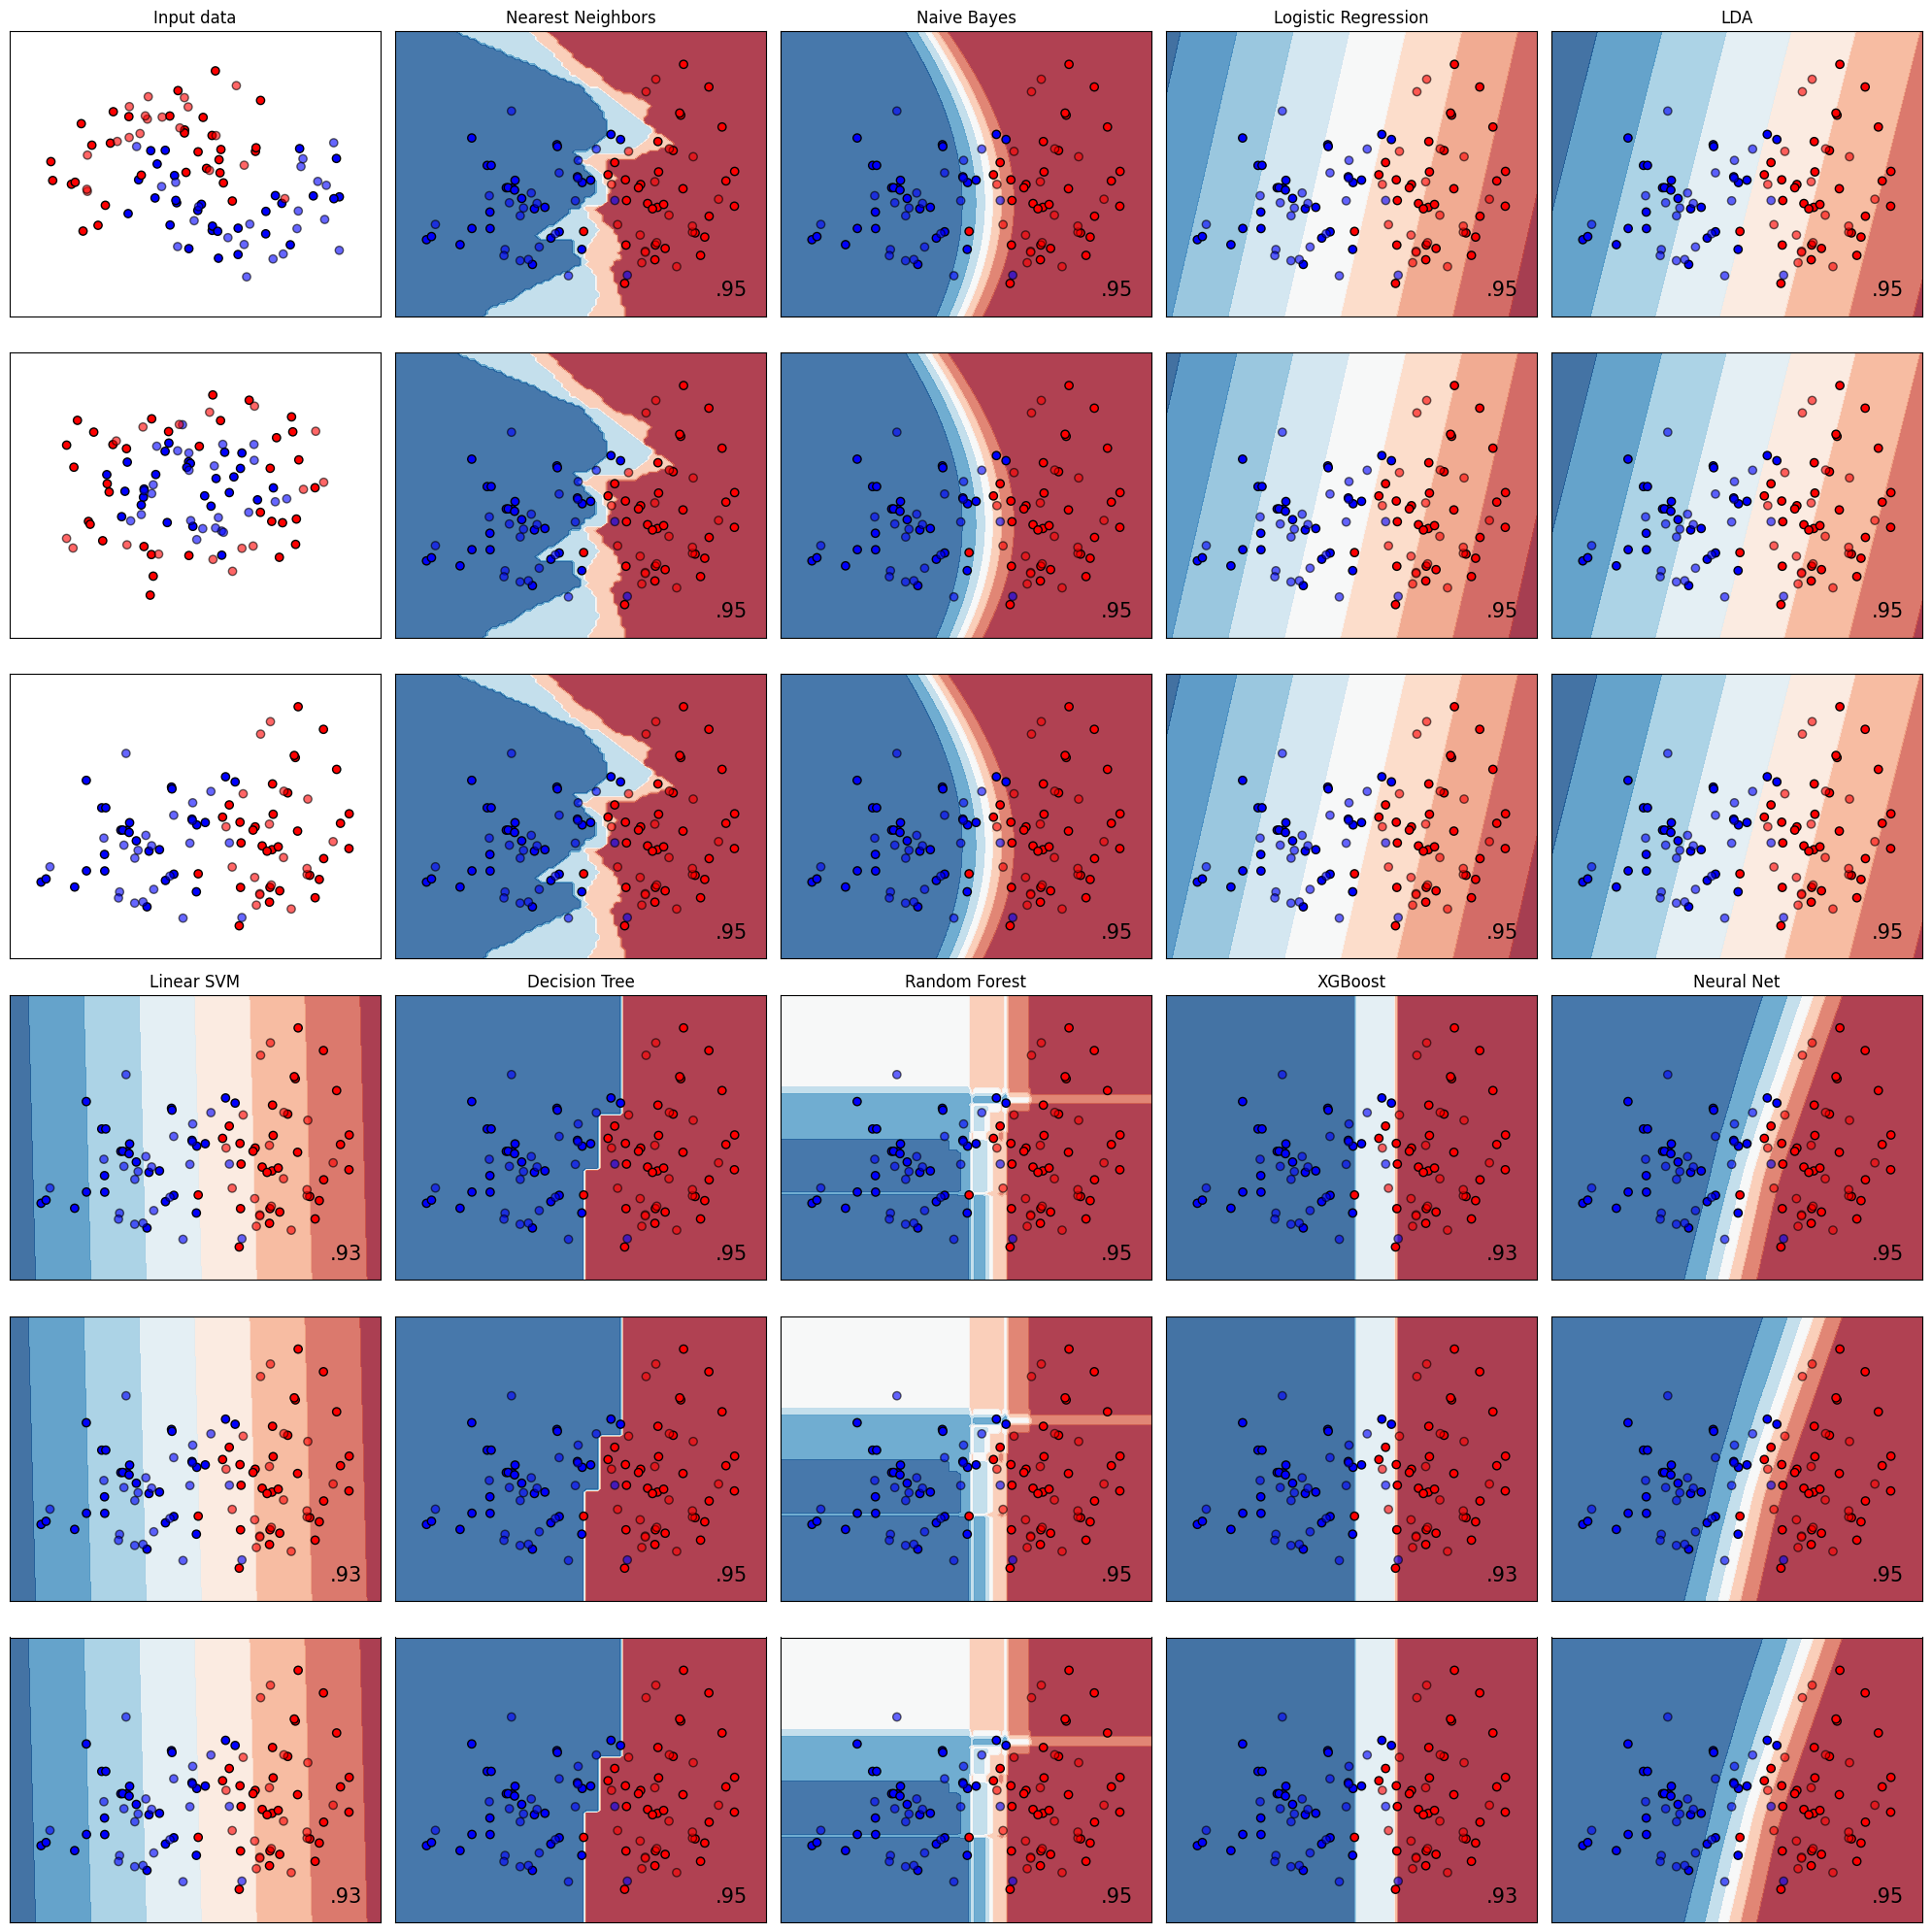

In [ ]:
names = [
    "Nearest Neighbors",
    "Naive Bayes",
    "Logistic Regression",
    "LDA",
    "Linear SVM",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "Neural Net"
]

classifiers = [
    KNeighborsClassifier(3),
    GaussianNB(),
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    SVC(kernel="linear", C=0.025, random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42),
    XGBClassifier(objective="binary:logistic", num_parallel_tree=4, n_estimators=10, max_depth=5, subsample=1.0, learning_rate=1e-1),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42)
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]


figure = plt.figure(figsize=(20, 20))
classes = len(classifiers) + 1
rows = int(len(datasets) * 2)
cols = classes // 2
gs = GridSpec(rows, cols, figure=figure)

row = 0
col = 0
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(gs[row, col])
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    row = (row + 1) % len(datasets)
    

# iterate over classifiers
for i, (name, clf) in enumerate(zip(names, classifiers)):
    col = (col + 1) % cols
    for ds_cnt, ds in enumerate(datasets):
        row = ((row + 1) % len(datasets)) + (len(datasets) * ((i+1) // cols))
        ax = plt.subplot(gs[row, col])

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == len(datasets) - 1:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )

plt.tight_layout()
plt.savefig(os.path.join(outpath, f"Classifiers_example.png"), bbox_inches="tight", dpi=600)
plt.show()

## Transfer to other dataset

In [6]:
algorithms_pretrained = ["Extreme gradient boosting RF", "Linear Discriminant Analysis"]
metrics_pretrained = ["eval_metrics"]

f"{algorithms_pretrained[0]}_{source}_{metrics_pretrained[0]}.tsv"

'Extreme gradient boosting RF_Com8_equal_conc_comb_eval_metrics.tsv'

In [38]:
from FIA.FIA import *
from ML.ML4com import *
from helpers.normalization import *
from sklearn.impute import KNNImputer

In [8]:
met_raw_pos_ec = pd.read_excel( "../../data/Com8_equal_conc_comb/20240702_FIA-Data_com8_equal_comb_mimedb_raw.xlsx", sheet_name="pos" )
met_raw_neg_ec = pd.read_excel( "../../data/Com8_equal_conc_comb/20240702_FIA-Data_com8_equal_comb_mimedb_raw.xlsx", sheet_name="neg" )
met_raw_pos_gt = pd.read_excel( "../../data/Com8_grown_together/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="pos" )
met_raw_neg_gt = pd.read_excel( "../../data/Com8_grown_together/FIA-Data Com8_20230717_P0024_msAV206-312.xlsx", sheet_name="neg" )

In [9]:
met_raw_comb_ec = pd.concat( [  total_ion_count_normalization( join_df_metNames(met_raw_pos_ec, grouper="mass", include_mass=True) ),
                                total_ion_count_normalization( join_df_metNames(met_raw_neg_ec, grouper="mass", include_mass=True) ) ] )
met_raw_comb_gt = pd.concat( [  total_ion_count_normalization( join_df_metNames(met_raw_pos_gt, grouper="mass", include_mass=True) ),
                                total_ion_count_normalization( join_df_metNames(met_raw_neg_gt, grouper="mass", include_mass=True) ) ] )

met_comb_ec = met_raw_comb_ec.loc[:, ["MS" in col for col in met_raw_comb_ec.columns]]
met_comb_gt = met_raw_comb_gt.loc[:, ["MS" in col for col in met_raw_comb_gt.columns]]

In [45]:
df_merged = intersect_impute_on_left(met_comb_gt, met_comb_ec, imputation="mean")

## Significance testing

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from significance_analysis import *

sns.set_theme(rc={"figure.figsize":(12, 6)})